In [1]:
from __future__ import annotations
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import urllib
import numpy as np
import PIL
import subprocess
import os
from typing import List, Tuple, Dict, Any, Optional
import time as ptime
import helpers

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from importlib import reload

In [3]:
reload(helpers)

<module 'helpers' from '/home/developer/diffusion/helpers.py'>

In [7]:
DEVICE = torch.device("cuda:1")
IMAGE_SHAPE = (32, 32)

# UNet definition

Extend the `MyNnBlock` class in such a way that it can condition the image synthesis on the class label.

In [4]:
class MyUNet(nn.Module):
    def __init__(self,
                 num_img_channels: int = 3,
                 dim_time_embedding: int = 128,
                 condition_on_labels: bool = False,
                 sequence_channels: List[int] =[64, 128, 256, 512, 1024]
                ):
        super(MyUNet, self).__init__()
        self.num_img_channels = num_img_channels
        self.dim_time_embedding = dim_time_embedding
        self.sequence_channels = sequence_channels
        self.condition_on_labels = condition_on_labels
        
        self.downsampling = nn.ModuleList([MyNnBlock(
            dim_channels_in=dci,
            dim_channels_out=dco,
            dim_time_embedding=self.dim_time_embedding,
            condition_on_labels=self.condition_on_labels,
            downsample=True
        ) for dci, dco in zip(self.sequence_channels[:-1], self.sequence_channels[1:])])
        self.upsampling = nn.ModuleList([MyNnBlock(
            dim_channels_in=dci,
            dim_channels_out=dco,
            dim_time_embedding=self.dim_time_embedding,
            condition_on_labels=self.condition_on_labels,
            downsample=False
        ) for dci, dco in zip(self.sequence_channels[::-1][:-1], self.sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(
            in_channels=self.num_img_channels,
            out_channels=self.sequence_channels[0],
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=sequence_channels[0],
            out_channels=self.num_img_channels,
            kernel_size=1
        )
    
    def forward(self, x, t, **kwargs):
        """
        Predicts the nosie that was added to x_t at x_{t-1}.
        
        Args:
            x_t: Denoised image at step t, has shape (B, C, W, H).
            t: the time step, has shape (B,).
            
        Kwargs:
            label: The class label the image belongs to, has shape (BS,).
        
        Returns:
            The prediction of the noise that was added to each pixel to get from x_{t-1} to x_{t}.
        """
        residuals = []
        latent = self.conv1(x)
        for ds in self.downsampling:
            latent = ds(latent, t, **kwargs)
            residuals.append(latent)
        for us, res in zip(self.upsampling, reversed(residuals)):
            latent = us(torch.cat((latent, res), dim=1), t, **kwargs)
        return self.conv2(latent)

In [5]:
class MyNnBlock(nn.Module):
    def __init__(self, dim_channels_in: int, dim_channels_out: int, dim_time_embedding: int,
                condition_on_labels: bool, num_filters=3, downsample=True):
        super(MyNnBlock, self).__init__()
        """
        One submodule of the UNet.
        
        Args:
            dim_channels_in: The number of channels per pixels the input image has.
            dim_channels_out: The number of channels the processed image has.
            dim_time_embedding: The dimensionality of the time step's embedding.
            condition_on_labels: Whether NN should condition the image synthesis on a class label.
            num_fitlers: The number of filters, i.e., kernel size of convolutional layers.
            downsample: Whether the block is on the left or right side of the U.
        """
        self.dim_channels_in = dim_channels_in
        self.dim_channels_out = dim_channels_out
        self.dim_time_embedding = dim_time_embedding
        self.condition_on_labels = condition_on_labels
        self.num_filters = num_filters
        self.downsample = downsample
        
        self.activation_fct = nn.ReLU()
        self.time_embedding = PositionalEncoding(self.dim_time_embedding)
        
        if self.condition_on_labels:
            self.label_mlp = nn.Linear(1, dim_channels_out)
        
        self.conv1 = nn.Conv2d(
            in_channels=dim_channels_in if self.downsample else 2 * dim_channels_in,
            out_channels=dim_channels_out,
            kernel_size=num_filters,
            padding=1
        )
        if self.downsample:
            self.final = nn.Conv2d(
                in_channels=dim_channels_out,
                out_channels=dim_channels_out,
                kernel_size=4,
                stride=2,
                padding=1
            )
        else:
            self.final = nn.ConvTranspose2d(
                in_channels=dim_channels_out,
                out_channels=dim_channels_out,
                kernel_size=4,
                stride=2,
                padding=1
            )
        self.batch_norm1 = nn.BatchNorm2d(dim_channels_out)
        self.batch_norm2 = nn.BatchNorm2d(dim_channels_out)
        
        self.conv2 = nn.Conv2d(
            in_channels=dim_channels_out,
            out_channels=dim_channels_out,
            kernel_size=3,
            padding=1
        )
        self.time_mlp = nn.Linear(dim_time_embedding, dim_channels_out)
        
    def forward(self, x: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Predicts the nosie that was added to x_t at x_{t-1}.
        
        Args:
            x_t: Denoised image at step t, has shape (B, C, W, H).
            t: the time step, has shape (B,).
        
        Returns:
            The prediction of the noise that was added to each pixel to get from x_{t-1} to x_{t}.
        """
        latent_x = self.batch_norm1(self.activation_fct(self.conv1(x)))
        latent_t = self.activation_fct(self.time_mlp(self.time_embedding(t)))
        latent_x = latent_x + latent_t.unsqueeze(-1).unsqueeze(-1)
        # ----> Exercise 6: Add support for label conditioning here.
        if self.condition_on_labels:
            label = kwargs.get('labels')
            latent_l = self.activation_fct(self.label_mlp(label))
            latent_x = latent_x + latent_l.unsqueeze(-1).unsqueeze(-1)
        # <----
        latent_x = self.batch_norm2(self.activation_fct(self.conv2(latent_x)))
        return self.final(latent_x)

Define a composition of functions that takes in image as input and performs the following tasks:

1. resizes an input image to `IMAGE_SHAPE`,
2. converts the resized image to a tensor into $[0,1]$,
3. rescales data into the interval $[-1, 1]$.

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (2 * x) - 1)
])

Define a composition of functions that reverses the process of `img_transform`, The composition takes as input a `torch.Tensor` object and returns a `PIL.Image.Image` object. Specifically, the composition should:

1. compute the inverse of the third function in `img_transform`,
2. Permute the channels from CHW to HWC,
3. Scale the data to the range $[0, 255]$,
4. Convert the tensor into a numpy array of type int8,
5. convert teh numpy image to a PIL.Image.Image object

In [9]:
# In torch, the convention is that the channel dimension follows the batch size, i.e.,
# batch size, channels, height, width.
# In numpy, the channel dimension is the last one, i.e., its batch size, height, width, channels.
img_transform_inverse = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2),
    transforms.Lambda(lambda x: x.permute(1, 2, 0)), # 0th dim, i.e., channels is put at the end, no batch size here.
    transforms.Lambda(lambda x: x * 255.),
    transforms.Lambda(lambda x: x.cpu().numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

# Shiba Inu use-case

In [10]:
print(f"Therer are {torch.cuda.device_count()} two GPUs on the system.")

Therer are 2 two GPUs on the system.


## Exercise 1

Add to the class `DiffusionModel` the static parts, specifically, given the start, end, and duration of a schedule, compute the $\beta_t$ parameters, the $\alpha_t$ parameters, and the $\overline{\alpha}_t\doteq\overline{\alpha}_{t-1}\alpha_t$, with $\overline{\alpha}_1\doteq\alpha_1$

In [11]:
class DiffusionModel(helpers.AbstractDiffusionModel):
    def __init__(self,
                 schedule_start: float = 0.0001,
                 schedule_end: float = 0.02,
                 num_timesteps: int = 300) -> 'DiffusionModel':
        super(DiffusionModel, self).__init__()
        self.schedule_start = schedule_start
        self.schedule_end = schedule_end
        self.num_timesteps = num_timesteps
        
        # ----> Exercise 1: Implement the definition of the betas, alphas, and \overline{alphas} here
        self.betas = torch.linspace(self.schedule_start, self.schedule_end, self.num_timesteps)
        self.alphas = 1 - self.betas
        self.overline_alphas = torch.cumprod(self.alphas, axis=0)
        # <----
        
    def forward(self, x_0: torch.Tensor, t: torch.Tensor, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Performs the foward diffusion process, i.e., starts with an image and returns noise.
        
        Args:
            x_0: Sample from the data distribution with shape (B, C, H, W).
            t: Time step in the forward diffusion process with shape (B,).
            device: Cuda device computations are performed on.
        
        Returns:
            The diffused image and the noise that was added to it.
        """
        # ----> Exercise 3: Implement one step of the forward diffusion process here
        noise = torch.randn_like(x_0, device=device)
        sqrt_overline_alphas_t = self.gather_from_list(torch.sqrt(self.overline_alphas.to(device)), t, x_0.ndim - 1)
        sqrt_one_minus_overline_alphas_t = self.gather_from_list(torch.sqrt(1 - self.overline_alphas.to(device)), t, x_0.ndim - 1)

        mu = sqrt_overline_alphas_t * x_0
        variance = sqrt_one_minus_overline_alphas_t * noise
        x_t = mu + variance
        # <-----
        
        return x_t, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x_t: torch.Tensor, t: torch.Tensor | int, model: torch.Module, **kwargs) -> torch.Tensor:
        """
        Perform one step in the backwards diffusion process.
        
        Args:
            x_t: Image at time t of shape (B, C, H, W).
            t: Time step in the backward diffusion process with shape (B,) or an integer.
            model: NN to predict the noise that was added to get from x_{t-1} to x_t.
            kwargs: Arguments that the function passes to the model.
            
        Returns:
            The estimate of the mean of image at time x_{t-1}.
        """
        # ----> Exercise 5: Implement one step of the backward diffusion process here.
        betas_t = self.gather_from_list(self.betas.to(t.device), t, x_t.ndim - 1)
        sqrt_one_minus_overline_alphas_t = self.gather_from_list(
            values=torch.sqrt(1 - self.overline_alphas.to(t.device)),
            indices=t,
            ndims=x_t.ndim - 1
        )
        sqrt_one_over_alphas_t = self.gather_from_list(
            values=torch.sqrt(1 / self.alphas.to(t.device)), 
            indices=t, 
            ndims=x_t.ndim - 1
        )
        predicted_noise = model(x_t, t, **kwargs)
        mu = sqrt_one_over_alphas_t * (x_t - betas_t * predicted_noise / sqrt_one_minus_overline_alphas_t)
        posterior_variance_t = betas_t
        
        if t == 0:
            x_t_minus_one = mu
        else:
            noise = torch.randn_like(x_t)
            variance = torch.sqrt(posterior_variance_t) * noise
            x_t_minus_one = mu + variance
        # <-----
        return x_t_minus_one

## Exercise 2

Create a functor deriving from `nn.Module` that returns the transformer sinuisidal positional encoding.

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim: int):
        super(PositionalEncoding, self).__init__()
        # ------> Exercise 2: Implement the constant positional encoding part here.
        self.dim = dim
        self.half_dim = self.dim // 2
        self.embedding = np.log(10000) / (self.half_dim - 1)
        self.embedding = torch.exp(torch.arange(self.half_dim, dtype=torch.float32) * (-1. * self.embedding))
        # <------
    
    def forward(self, position: torch.Tensor) -> torch.Tensor:
        """
        Computes the positional encodings for the positions.
        
        Args:
            position: Tensor with inputs representing some form of 1D position. Has shape (BS,).
            
        Returns:
            An embedding of the position based on Sin and Cos, has shape (BS, 2 * self.half_dim).
        """
        # ----> Exercise 2: Implement the dynamic encoding part here.
        device = position.device
        embeddings = position.unsqueeze(1) * self.embedding.to(device).unsqueeze(0)
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        # <----
        return embeddings

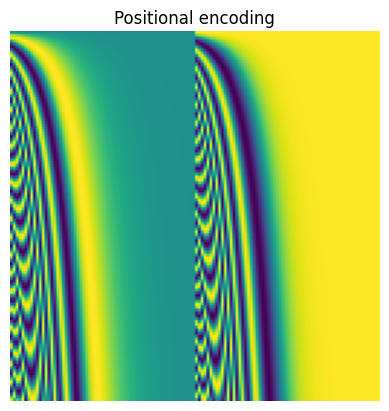

In [13]:
encoding = PositionalEncoding(128)
helpers.plot_encoding(encoding)

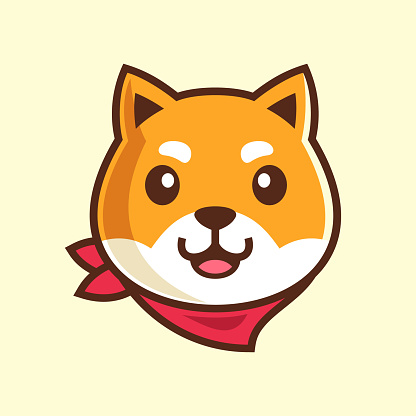

In [14]:
shiba_img = helpers.get_shiba()
shiba_img

In [15]:
shiba_img_torch = helpers.img_transform(shiba_img)

## Exercise 3

Implement the `forward` method in the `DiffusionModel` class. Implement the following algorithm

TODO: add algorithm pseudo code

In [16]:
diffusion_model = DiffusionModel()

<Figure size 1500x1500 with 0 Axes>

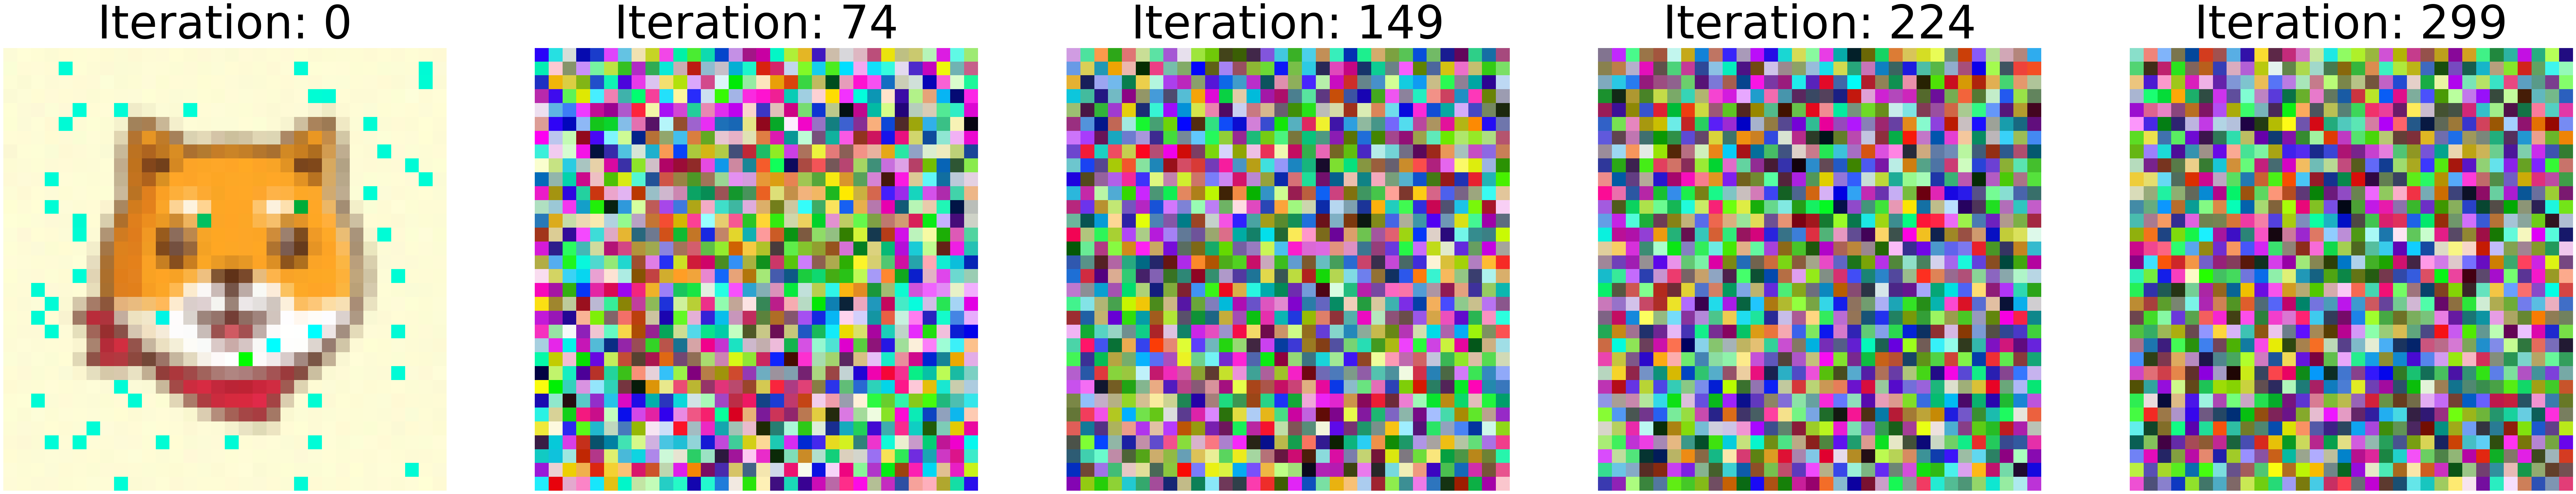

In [17]:
helpers.visualize_forward_diffusion(shiba_img_torch, diffusion_model)

In [18]:
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.0001
BATCH_SIZE = 128
VERBOSE = True

unet = MyUNet()
unet.to(DEVICE)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

## Exercise 4

Implement the training of the unet. Overfit to the Shiba Inu picture (or any picture you like). Implement the following algorithm:

**repeat**  
&ensp; $x_0\sim q(x_0)$  
&ensp; $t\sim\text{Uniform}(\lbrace 1,\ldots,T\rbrace)$  
&ensp; $\epsilon\sim\mathcal{N}(0, I)$  
&ensp; Take gradient descent step on:  
&ensp; $\nabla\parallel\epsilon-\epsilon_{\theta}(\sqrt{\overline{\alpha}_t}x_0+\epsilon\sqrt{1-\overline{\alpha}_t},t)\parallel^2$  
**until** convergence

In [64]:
t_start = ptime.time()
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    
    batch = torch.stack([shiba_img_torch.to(DEVICE)] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.num_timesteps, (BATCH_SIZE,)).long().to(DEVICE)

    # ---> Exercise 5: Implement the training step here.
    batch_noisy, noise = diffusion_model.forward(batch, t, DEVICE) 
    predicted_noise = unet(batch_noisy, t)
    
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    # <---
    
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Took {(ptime.time() - t_start) / 60}min")
        t_start = ptime.time()
        if VERBOSE:
            with torch.no_grad():
                helpers.plot_noise_prediction(noise[0], predicted_noise[0])
                helpers.plot_noise_distribution(noise, predicted_noise)

---
Epoch: 0 | Train Loss 0.007672149688005447 | Took 0.005329267183939616min
---
Epoch: 20 | Train Loss 0.007285315077751875 | Took 0.11935617129007975min


## Exercise 5
Implement the `backward` method in the `DiffusionModel` class.

Sample an image from the trained model. Visualize every 10th denoising step using the `visualize_img` helper function. Implement the following algorithm:

$x_T\sim\mathcal{N}(0, I)$  
**for** $t=T,\ldots,1$ **do**  
&ensp;$z\sim\mathcal{N}(0, I)$ if $t>1$, else $z=0$  
&ensp;$x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_{\theta}(x_t, t)\right)+\sigma_{t}z$  
**end for**  
**return** $x_0$

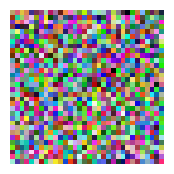

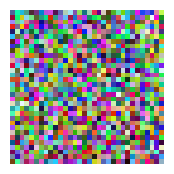

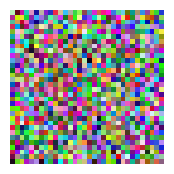

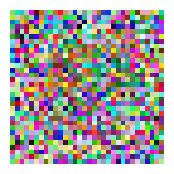

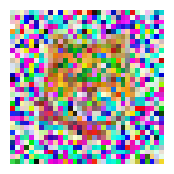

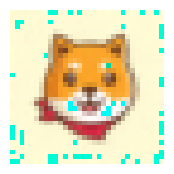

In [68]:
with torch.no_grad():
    # ---> Exercise 5: Implement your code here.
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(DEVICE)
    for i in reversed(range(diffusion_model.num_timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=DEVICE)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            helpers.visualize_image(img)
    # <---

# Street Signs

In [64]:
def do_epoch(data_loader, unet, optimizer):
    mean_epoch_loss = []
    for batch, label in data_loader:
        batch = batch.to(DEVICE)
        # ---> Exercise 6: Implement training step here.
        t = torch.randint(0, diffusion_model.num_timesteps, (BATCH_SIZE,)).long().to(DEVICE)
        batch_noisy, noise = diffusion_model.forward(batch, t, DEVICE) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(DEVICE))
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        # <---
        mean_epoch_loss.append(loss.item())

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return mean_epoch_loss

In [65]:
def train_network(unet: torch.Model, optim: torch.optim.Adam,
                  trainloader: torch.utils.data.DataLoader,
                  testloader: torch.utils.data.DataLoader,
                  nn_name: str, no_epochs: int,
                  print_frequency: int, verbose=False) -> torch.Model:
    t_start = ptime.time()
    best_val_loss = 1e9
    best_epoch = 0
    for epoch in range(no_epochs):
        mean_epoch_loss = []
        mean_epoch_loss_val = []
        mean_epoch_loss = do_epoch(trainloader, unet, optimizer)

        if epoch % print_frequency == 0:
            with torch.no_grad():
                mean_epoch_loss_val = do_epoch(testloader, unet, None)
            avg_val_loss = np.mean(mean_epoch_loss_val)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                addendum = " New best!"
            else:
                addendum = ''
            print('---')
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | "
                  f"Val Loss {avg_val_loss}{addendum}| "
                  f"Took {(ptime.time() - t_start) / 60:.2f} Min")
            t_start = ptime.time()
            if verbose:
                with torch.no_grad():
                    helpers.plot_noise_prediction(noise[0], predicted_noise[0])
                    helpers.plot_noise_distribution(noise, predicted_noise)
            torch.save(unet.state_dict(), f"{nn_name}-epoch-{epoch}")
    print(f"Best model was in epoch {best_epoch} with a validation loss of {best_val_loss}. "
          f"Stored in {nn_name}-epoch-{best_epoch}")
    return unet

In [87]:
BATCH_SIZE = 256
NO_EPOCHS = 31
PRINT_FREQUENCY = 3
LR = 0.001
VERBOSE = False

unet_gtsrb = MyUNet(condition_on_labels=True)
unet_gtsrb.to(DEVICE)
optimizer = torch.optim.Adam(unet_gtsrb.parameters(), lr=LR)

In [88]:
reload(helpers)

<module 'helpers' from '/home/developer/diffusion/helpers.py'>

In [89]:
trainset = torchvision.datasets.GTSRB(root='./data', split='train', download=True, transform=helpers.img_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=helpers.img_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

In [ ]:
unet_gtsrb = train_network(unet_gtsrb, optimizer, trainloader, testloader, 'unet-gtsrb', NO_EPOCHS, PRINT_FREQUENCY)

---
Epoch: 0 | Train Loss 0.43305728412591493 | Val Loss 0.13067161580737757 New best!| Took 0.57 Min
---
Epoch: 3 | Train Loss 0.07370330697785203 | Val Loss 0.069421436865719 New best!| Took 1.59 Min
---
Epoch: 6 | Train Loss 0.06636948926517597 | Val Loss 0.0648881367274693 New best!| Took 1.60 Min
---
Epoch: 9 | Train Loss 0.05989924216499695 | Val Loss 0.060787170593227656 New best!| Took 1.60 Min


In [81]:
names = ["speed 20", "speed 30", "speed 50", "speed 60", "speed 70", "speed 80"
        "speed 100", "speed 120", "ueberholverbot pkw", "ueberholverbot LKW",
        "Durchfahrt verboten", "Duchfahrt verboten LKW",
         
        "Vorfahrtsstrasse kreuzt", "Vorsicht",
        "Scharfe rechtskurve", "scharfe linkskurve", "Kurvig", "Huegellig",
        "Slippery", "Fahrbanverengung", "Baustelle", "Ampel", "Fussgaenger",
        "Kinder", "Fahrrad", "Glaette", "Wild"
         
         "Nur rechts", "Nur links", "nur geradeaus", "geradeaus und rechts",
         "geradeaus und links", "Auf rechte Spur", "Auf linke Spur",
         "Kreisverkehr",
         
         "Vorfahrt", "Vorfahrt achten", "Stop", "Ende Einbahnstrasse", "Aufhebung 80",
         "Aufhebung alle", "Aufhebunk PKW ueberhol", "Aufhebung LKN ueberhol"
        ]

In [82]:
idx = [0, 8, 21, 29, 36, 37, 38, 39, 40]

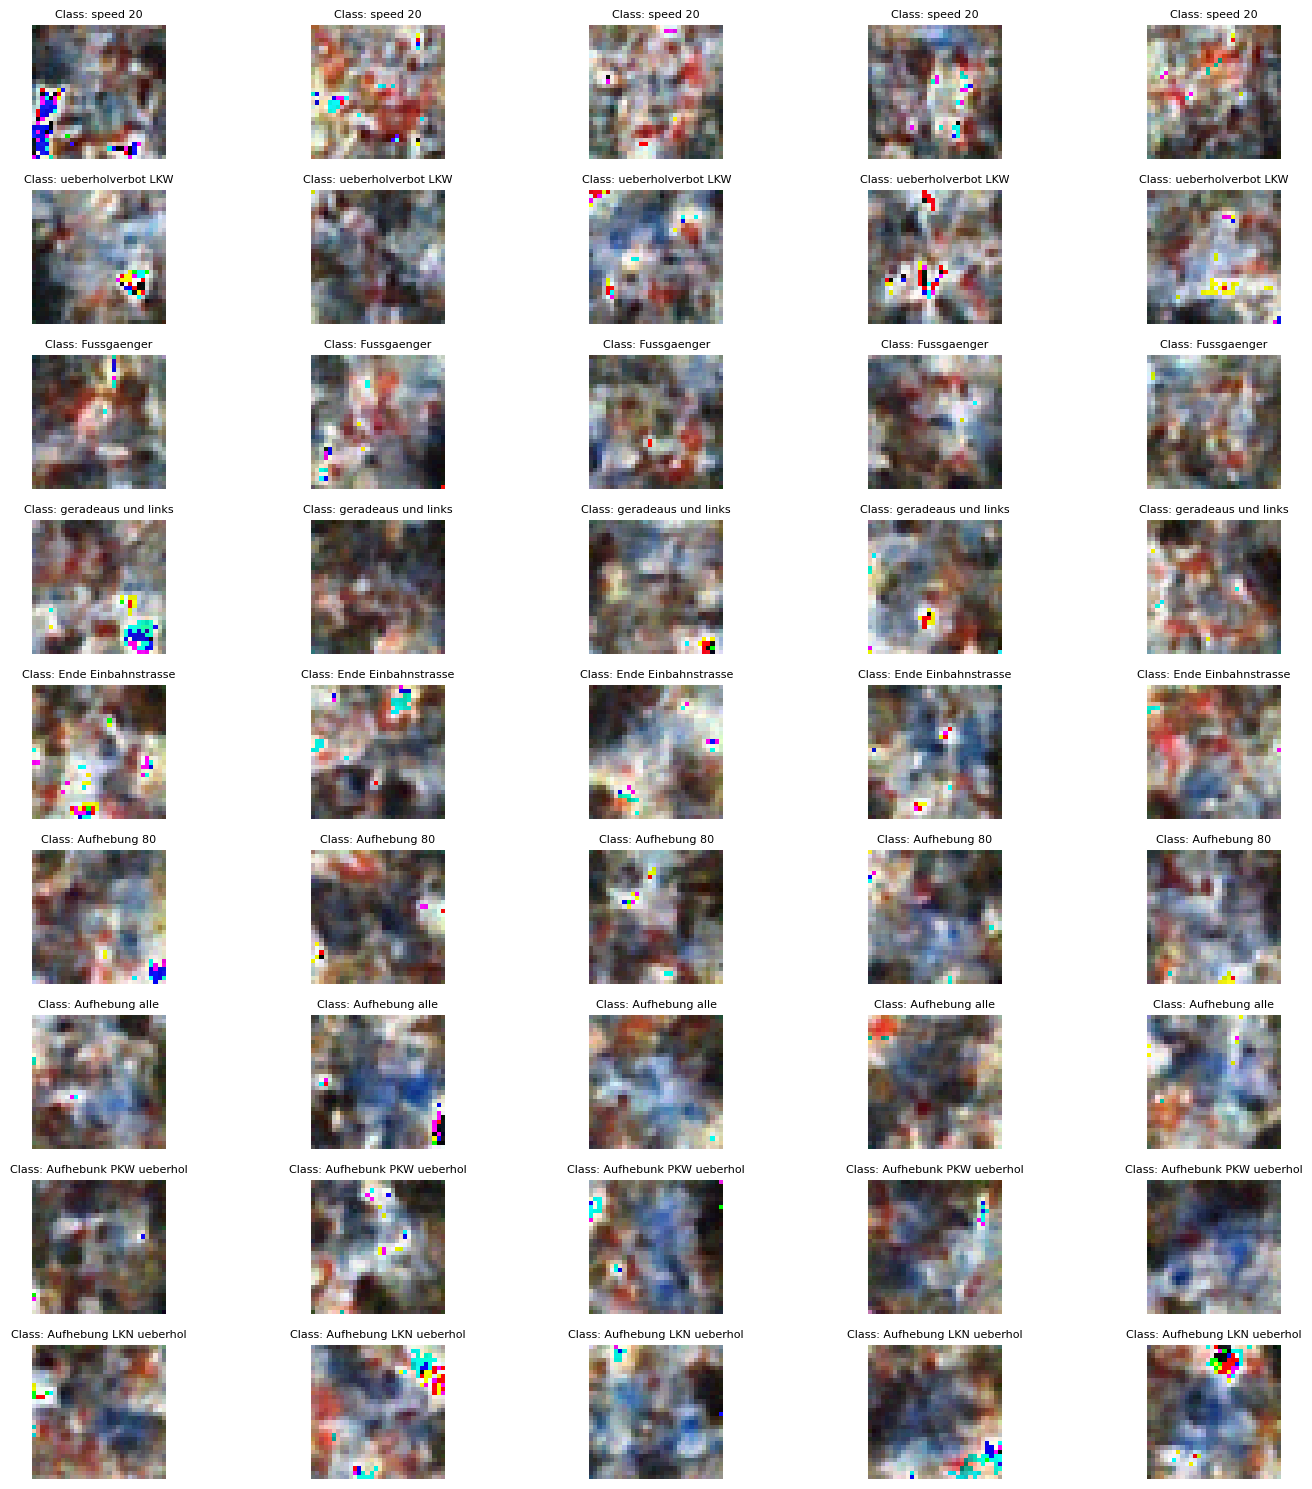

In [83]:
helpers.visualize_trained_classconditioned_unet(diffusion_model, unet_gtsrb, [names[i] for i in idx], idx, 5, DEVICE)